# **Task 1: LLM Fundamentals & Generation Analysis**

## **Overview**
This task provides a **hands-on introduction** to the fundamentals of large language models (LLMs) using the **Llama 3-8B Instruct** model.  
It walks through model loading, text generation experiments, and key performance analyses, focusing on **latency**, **diversity**, and **memory usage**.

---

## **Step 1: Environment Setup (Cell 2)**

- **Objective:**  
  Create a clean and reproducible environment for running all experiments.

- **Actions:**
  - **Import Libraries:**  
    Load all required libraries for model handling, generation, and visualization.  
  - **Configure Environment:**  
    Define a `set_seed` function to ensure reproducibility by fixing random seeds.  
    Verify that a **GPU** is available for efficient computation.

---

## **Step 2: Model Loading (Cell 4)**

- **Objective:**  
  Load the target **Llama 3-8B Instruct** model and prepare it for inference.

- **Actions:**
  - **Select Model:**  
    Set `MODEL_ID = "meta-llama/Meta-Llama-3-8B-Instruct"`.  
  - **Load with Fallback:**  
    Use a `try...except` block to attempt loading the main model.  
    If it fails (e.g., due to limited memory), load a smaller fallback model (`FALLBACK_MODEL_ID`) to ensure the notebook remains executable.  
  - **Model Summary:**  
    Print key information about the loaded model, including size and configuration.

---

## **Step 3: Experiment 1 — Effect of Temperature on Diversity (Cell 5)**

- **Objective:**  
  Understand how the **temperature** hyperparameter influences the **randomness and diversity** of generated text.

- **Actions:**
  - **Set Parameters:**  
    Define a fixed input `PROMPT` and a list of `TEMPERATURES` to test.  
  - **Generate Samples:**  
    Loop through each temperature value and generate multiple text samples using  
    `model.generate(..., do_sample=True)` so that temperature actually affects randomness.  
  - **Record Results:**  
    Save all generated outputs for side-by-side comparison and qualitative analysis.

---

## **Step 4: Experiment 2 — Input Length vs. Prefill Latency (Cell 6)**

- **Objective:**  
  Demonstrate that **longer input sequences** lead to **higher prefill latency** before generation begins.

- **Actions:**
  - **Define Input Sizes:**  
    Create a list of token lengths (`INPUT_LENGTHS`) to test various input sizes.  
  - **Precise Timing:**  
    Use `torch.cuda.Event` for high-precision GPU time measurement.  
  - **Measure Prefill Stage:**  
    For each input length, perform warm-up runs, then measure time for generating one token (`max_new_tokens=1`) to isolate prefill cost.  
  - **Visualize:**  
    Plot a line graph showing **input length (x-axis)** vs. **average latency (y-axis)**.

---

## **Step 5: Experiment 3 — Real-Time Memory Tracking During Generation (Cell 8)**

- **Objective:**  
  Track and visualize **GPU memory usage** step-by-step as tokens are generated, illustrating the growth of the **KV Cache**.

- **Actions:**
  - **Design a “Memory Hook”:**  
    Implement a custom class `MemoryUsageCallback` inheriting from `transformers.StoppingCriteria`.  
    Its `__call__` method records current GPU memory after each token generation, returning `False` to continue.  
  - **Run Monitored Generation:**  
    After GPU warm-up, create an instance of the callback and pass it to `model.generate()` via `stopping_criteria`.  
  - **Analyze and Plot:**  
    Convert recorded memory data into a DataFrame and plot the **memory usage curve** over generation steps.

---

## **Step 6: Verifying the Space Complexity of KV Cache (Cell 9)**

- **Objective:**  
  Quantitatively confirm that memory usage grows **linearly** with sequence length — proving **O(L)** space complexity for the KV Cache.

- **Actions:**
  - **Linear Regression:**  
    Apply `scipy.stats.linregress` to fit a linear model between the number of generated tokens and memory increase.  
  - **Interpret Results:**  
    - The **slope** indicates average memory growth (in MB) per generated token.  
    - The **R² value** close to 1 (e.g., > 0.99) validates a strong linear correlation, confirming the **O(L)** relationship.

---

## **Step 7: Summary and Analysis (Cell 10)**

- **Objective:**  
  Summarize all experimental findings and explain the underlying principles observed.

- **Actions:**
  - **Write Analysis:**  
    Discuss results and plots from all experiments, highlighting:  
    - The trade-off between temperature and diversity.  
    - The linear scaling of prefill latency with input length.  
    - The direct, linear memory growth due to KV caching.  
  - Synthesize these insights into a clear, data-driven conclusion about **LLM generation efficiency** and **scalability**.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
### Cell 2: Environment Setup and Dependency Installation
# TODO: import all required libraries for the lab (os, random, time, numpy, pandas, torch, transformers, etc.)
import os
import random
import numpy as np
import pandas as pd
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, StoppingCriteria
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional

BASE_DIR = "/content/drive/MyDrive/eml-lab4"
RESULTS_DIR = os.path.join(BASE_DIR, "results")
FIGURES_DIR = os.path.join(BASE_DIR, "figures")

# TODO: create the results/figures directories if they do not exist
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

# TODO: configure logging verbosity and select DEVICE (cuda vs. cpu)
# logging.set_verbosity_warning()
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    # print GPU diagnostics here
else:
    DEVICE = torch.device("cpu")
    # print CPU-only notice

# TODO: print environment diagnostics (CUDA version, PyTorch version, etc.)

def set_seed(seed: int = 42) -> None:
    """Seed Python, NumPy, and PyTorch RNGs for reproducible lab runs."""
    ...
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # For deterministic behavior (slower, but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def require_gpu(task: str) -> None:
    """Raise a descriptive error if a GPU is required but not available."""
    ...
    if not torch.cuda.is_available():
        raise RuntimeError(f"A GPU is required for {task}, but none is available.")

# TODO: call set_seed and configure visualisation defaults (sns, matplotlib)
# sns.set_theme(...)
# plt.rcParams.update(...)
# print("Environment initialised.")
set_seed(42)

# Configure Seaborn and Matplotlib defaults
sns.set_theme(style="whitegrid")  # clean, readable plots
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

print("Environment initialised.")


Environment initialised.


In [3]:
# ### Cell 3: Hugging Face Login
from huggingface_hub import login, HfFolder
from getpass import getpass

# # Check if a Hugging Face token is already set in the environment.
if not os.getenv("HUGGING_FACE_HUB_TOKEN"):
    try:
        # Prompt user for Hugging Face access token if not found.
        hf_token = getpass("Please enter your Hugging Face access token: ")
        login(token=hf_token, add_to_git_credential=True)
        print("   Hugging Face login successful!")
    except Exception as e:
        print(f"Login failed: {e}. Model loading may fail later.")
else:
    print("   Hugging Face token detected.")

Please enter your Hugging Face access token: ··········
   Hugging Face login successful!


In [4]:
### Cell 4: Load Model and Tokenizer
MODEL_ID = "meta-llama/Meta-Llama-3-8B-Instruct"  # TODO: primary model identifier
FALLBACK_MODEL_ID = "meta-llama/Meta-Llama-3-8B"  # TODO: fallback model identifier

model: Optional[AutoModelForCausalLM] = None
tokenizer: Optional[AutoTokenizer] = None

candidates = [MODEL_ID, FALLBACK_MODEL_ID]

for candidate in candidates:
    # TODO: attempt to load tokenizer/model and break once successful
    try:
        print(f"Trying to load {candidate}...")
        tokenizer = AutoTokenizer.from_pretrained(candidate)
        model = AutoModelForCausalLM.from_pretrained(candidate, device_map="auto", torch_dtype=torch.float16)
        print(f"Loaded model: {candidate}")
        break
    except Exception as e:
        print(f"Failed to load {candidate}: {e}")

# TODO: raise an error if both candidates fail to load
if model is None or tokenizer is None:
    raise RuntimeError("Failed to load both primary and fallback models.")

# TODO: ensure tokenizer/model pad tokens are configured
if tokenizer.pad_token is None:
  tokenizer.pad_token = tokenizer.eos_token
  model.config.pad_token_id = tokenizer.pad_token_id

# TODO: move model to eval mode/device and print summary stats
model.eval()

num_params = sum(p.numel() for p in model.parameters()) / 1e9
device = next(model.parameters()).device
print(f"Model ready: {candidate}")
print(f"Parameters: {num_params:.2f}B")
print(f"Device: {device}")


Trying to load meta-llama/Meta-Llama-3-8B-Instruct...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Loaded model: meta-llama/Meta-Llama-3-8B-Instruct
Model ready: meta-llama/Meta-Llama-3-8B-Instruct
Parameters: 8.03B
Device: cuda:0


In [5]:
print([round(int(x) * 0.1, 1) for x in range(0, 10, 2)])
# Output: [0.0, 0.2, 0.4, 0.6, 0.8]

[0.0, 0.2, 0.4, 0.6, 0.8]


In [6]:
### Cell 5: Experiment 1 - Effect of Temperature on Generation Diversity
print("--- Experiment 1: Temperature sweep ---")

PROMPT = "To get into the Champion's League Everton should sign:\n"  # TODO: provide the experiment prompt
TEMPERATURES = [round(int(x) * 0.1, 1) for x in range(2, 10, 2)]  # TODO: define the temperatures to test
NUM_SAMPLES_PER_TEMP = 5 # TODO: samples per temperature
MAX_NEW_TOKENS = 100  # TODO: maximum generation length

# TODO: ensure model and tokenizer are loaded before running

records = []

for temp in TEMPERATURES:
    for sample_id in range(1, NUM_SAMPLES_PER_TEMP + 1):
        # TODO: tokenize prompt, generate completion, and decode output
        input_ids = tokenizer(
            text=PROMPT,
            return_tensors="pt"
        ).input_ids.to(device)

        output_ids = model.generate(
            input_ids,
            max_new_tokens=MAX_NEW_TOKENS,
            temperature=temp,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id
        )

        text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

        # Record results
        records.append({
            "temperature": temp,
            "sample_id": sample_id,
            "generated_text": text
        })

# TODO: build df_temperature and summary_temperature from records
df_temperature = pd.DataFrame(records)
summary_temperature = df_temperature.groupby("temperature").agg({
    "generated_text": "count"
}).rename(columns={"generated_text": "num_samples"})

# TODO: persist CSV artifacts and display summary statistics
df_temperature.to_csv(os.path.join(RESULTS_DIR, "temperature_sweep_samples.csv"), index=False)
summary_temperature.to_csv(os.path.join(RESULTS_DIR, "temperature_sweep_summary.csv"))

print("Temperature sweep complete. Summary statistics:")
print(summary_temperature)


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


--- Experiment 1: Temperature sweep ---
Temperature sweep complete. Summary statistics:
             num_samples
temperature             
0.2                    5
0.4                    5
0.6                    5
0.8                    5


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


--- Experiment 2: Input length vs. prefill latency ---


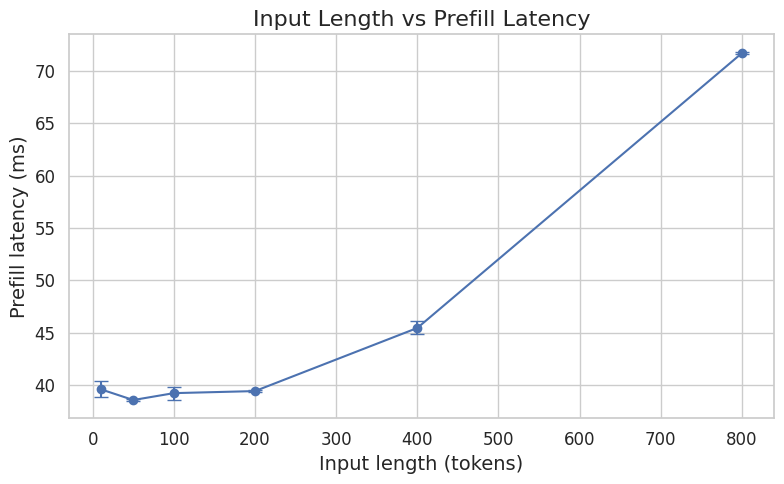

Input length vs. prefill latency experiment complete.


In [ ]:
### Cell 6: Experiment 2 - Effect of Input Length on Prefilling Latency
print("--- Experiment 2: Input length vs. prefill latency ---")

LATENCY_INPUT_LENGTHS = [10, 50, 100, 200, 400, 800]  # TODO: sorted list of token lengths
NUM_WARMUP = 2  # TODO: number of warmup passes
NUM_TRIALS = 5  # TODO: number of timed trials
MAX_NEW_TOKENS = 1  # TODO: max generation length per latency run

latency_records = []

for input_length in LATENCY_INPUT_LENGTHS:
    # TODO: build a dummy prompt of the desired token length
    # inputs = tokenizer(...)
    # warmup generations
    # time trial generations and record latency/throughput
    prompt = " ".join(["word"] * input_length)
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)

    for _ in range(NUM_WARMUP):
      _ = model.generate(
          input_ids,
          max_new_tokens=MAX_NEW_TOKENS,
          do_sample=False,
          pad_token_id=tokenizer.pad_token_id
      )

    for trial_id in range(1, NUM_TRIALS + 1):
      start_event = torch.cuda.Event(enable_timing=True)
      end_event = torch.cuda.Event(enable_timing=True)

      start_event.record()
      _ = model.generate(
          input_ids,
          max_new_tokens=MAX_NEW_TOKENS,
          do_sample=False,
          pad_token_id=tokenizer.pad_token_id
      )
      end_event.record()

      torch.cuda.synchronize()
      latency_ms = start_event.elapsed_time(end_event)

      latency_records.append({
          "input_length": input_length,
          "trial_id": trial_id,
          "latency_ms": latency_ms
      })

# TODO: assemble df_latency from latency_records
df_latency = pd.DataFrame(latency_records)
summary_latency = df_latency.groupby("input_length").agg(
    mean_latency_ms=("latency_ms", "mean"),
    std_latency_ms=("latency_ms", "std")
).reset_index()

# Persist CSV
df_latency.to_csv(os.path.join(RESULTS_DIR, "latency_raw.csv"), index=False)
summary_latency.to_csv(os.path.join(RESULTS_DIR, "latency_summary.csv"), index=False)

# TODO: compute summary statistics and optionally plot latency curves
plt.figure(figsize=(8, 5))
plt.errorbar(
    summary_latency["input_length"],
    summary_latency["mean_latency_ms"],
    yerr=summary_latency["std_latency_ms"],
    fmt="-o",
    capsize=5
)
plt.xlabel("Input length (tokens)")
plt.ylabel("Prefill latency (ms)")
plt.title("Input Length vs Prefill Latency")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "latency_curve.png"))
plt.show()

print("Input length vs. prefill latency experiment complete.")


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


--- Experiment 3: Real-time memory trace ---
    step  memory_bytes     memory_mb
95    96   16083847168  15338.751953
96    97   16083978240  15338.876953
97    98   16084109312  15339.001953
98    99   16084240384  15339.126953
99   100   16084371456  15339.251953


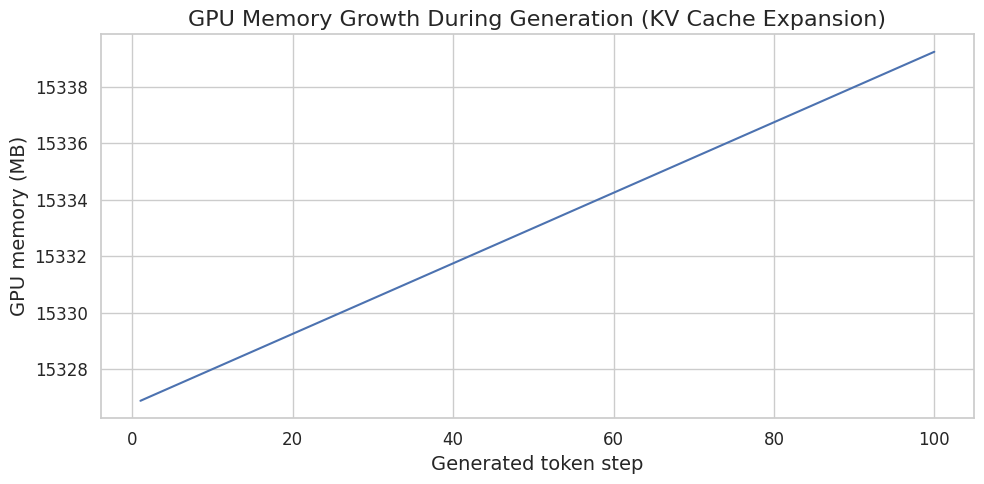

In [ ]:
### Cell 8: Experiment 3 - Real-time GPU Memory Usage During Generation
print("--- Experiment 3: Real-time memory trace ---")

df_memory_steps = pd.DataFrame()

if DEVICE.type != "cuda":
    print("Skipped: requires GPU trace from the previous cell.")
else:
    MAX_GENERATION_LENGTH = 100  # TODO: max tokens for traced generation
    PROMPT = "To get into the Champion's League Everton should sign:\n"  # TODO: seed prompt for memory trace
    INPUT_LENGTH = len(PROMPT)  # TODO: desired prompt length in tokens

    # TODO: prepare input_ids at the specified length
    input_ids = tokenizer(PROMPT, return_tensors="pt").input_ids.to(device)

    class MemoryUsageCallback(StoppingCriteria):
        def __init__(self, device):
            self.device = device
            self.memory_used = []
            self.steps = []

        def __call__(self, input_ids, scores, **kwargs):
            mem = torch.cuda.memory_allocated(self.device)
            self.memory_used.append(mem)
            self.steps.append(len(self.memory_used))
            return False

        def increases_mb(self):
            if len(self.memory_used) < 2:
                return []

            diffs = [self.memory_used[i] - self.memory_used[i - 1] for i in range(1, len(self.memory_used))]
            return [diff / (1024 * 1024) for diff in diffs]

    callback = MemoryUsageCallback(DEVICE)

    # TODO: run warmup generation without callback
    with torch.no_grad():
        _ = model.generate(
            input_ids,
            max_new_tokens=5,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id
        )

    # TODO: run traced generation with callback attached
    with torch.no_grad():
        _ = model.generate(
            input_ids,
            max_new_tokens=MAX_GENERATION_LENGTH,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id,
            stopping_criteria=[callback]
        )

    # TODO: convert callback outputs into df_memory_steps and save CSV
    df_memory_steps = pd.DataFrdf_memory_steps = pd.DataFrame({
        "step": callback.steps,
        "memory_bytes": callback.memory_used,
        "memory_mb": [m / (1024**2) for m in callback.memory_used]
    })

    df_memory_steps.to_csv(os.path.join(RESULTS_DIR, "memory_trace.csv"), index=False)

    # TODO: plot per-token memory increase and save the figure
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df_memory_steps, x="step", y="memory_mb")
    plt.xlabel("Generated token step")
    plt.ylabel("GPU memory (MB)")
    plt.title("GPU Memory Growth During Generation (KV Cache Expansion)")
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, "memory_trace.png"))

    print(df_memory_steps.tail())

In [ ]:
### Cell 9: Space Complexity Verification
from scipy.stats import  linregress

print("--- Space complexity verification ---")

if DEVICE.type != "cuda":
    print("Skipped: requires GPU trace from the previous cell.")
elif df_memory_steps.empty:
    print("No memory trace data available. Run Experiment 3 before this analysis.")
else:
    # TODO: run linear regression on df_memory_steps and report slope/intercept/R^2
    # slope, intercept, r_value, p_value, std_err = linregress(...)
    # print(...)
    x = df_memory_steps["step"].values
    y = df_memory_steps["memory_mb"].values

    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    print(f"Slope (MB per token): {slope:.4f} MB/token")
    print(f"Intercept (MB):       {intercept:.2f} MB")
    print(f"R^2:                  {r_value**2:.6f}")
    print(f"Std. Error:           {std_err:.6f}")
    print(f"P-value:              {p_value:.6e}")

    # Optional interpretation
    if r_value**2 > 0.99:
        print("Conclusion: Strong linear relationship detected. KV Cache memory grows O(L).")
    else:
        print("Conclusion: R² is lower than expected. Results may be noisy or require longer sequences.")


--- Space complexity verification ---
Slope (MB per token): 0.1250 MB/token
Intercept (MB):       15326.75 MB
R^2:                  1.000000
Std. Error:           0.000001
P-value:              0.000000e+00
Conclusion: Strong linear relationship detected. KV Cache memory grows O(L).


In [ ]:
### Cell 10: List all generated artifacts for Task 1
print("Task 1 complete. Generated artifacts:")

# TODO: iterate over output directories and list generated files
# if os.path.isdir(FIGURES_DIR):
#     ...
# if os.path.isdir(RESULTS_DIR):
#     ...
def list_dir(label, path):
    print(f"{label} ({path}):")
    if not os.path.isdir(path):
        print("  [Directory not found]\n")
        return

    files = sorted(os.listdir(path))
    if not files:
        print("  [No files found]\n")
        return

    for f in files:
        print(f"  - {f}")
    print()

list_dir("Figures", FIGURES_DIR)
list_dir("Results", RESULTS_DIR)


Task 1 complete. Generated artifacts:
Figures (/content/drive/MyDrive/eml-lab4/figures):
  - latency_curve.png
  - memory_trace.png

Results (/content/drive/MyDrive/eml-lab4/results):
  - latency_raw.csv
  - latency_summary.csv
  - memory_trace.csv
  - temperature_sweep_samples.csv
  - temperature_sweep_samples.gsheet
  - temperature_sweep_summary.csv

